## Workspace setup

In [3]:
from multiprocessing import Process, Queue
import tensorflow as tf
import numpy as np
from os.path import isfile
import io_functions as io


from tensorflow.data import Dataset, TFRecordDataset
from tensorflow.io import TFRecordWriter, TFRecordOptions
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

2023-11-26 08:16:34.347675: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## TFRecord creation

In [4]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def serialize(charge_array, target):
  feature = {'myChargeArray' : _bytes_feature(tf.io.serialize_tensor(charge_array)),
             'target' : _bytes_feature(tf.io.serialize_tensor(target))}
  example = tf.train.Example(features=tf.train.Features(feature=feature))
  return example.SerializeToString()

def conversion(filename, queue):
    options = TFRecordOptions(compression_type='GZIP')
    writer = TFRecordWriter(filename, options=options)
    while True:
        item = queue.get()
        if item == None:
            break
        charge_array, target = item
        charge_array= io.proc_features(charge_array)
        
        example = serialize(charge_array, target)
        writer.write(example)

In [29]:
def XYZtoUVWT(data):
    referencePoint = tf.constant([-138.9971, 98.25])
    phi = np.pi/6.0
    stripPitch = 1.5
    f = 1.0/25*6.46
    u = -(data[:, 1]-99.75)
    v = (data[:, 0]-referencePoint[0]) * np.cos(phi) - (data[:, 1]-referencePoint[1]) * np.sin(phi)
    w = (data[:, 0]-referencePoint[0]) * np.cos(-phi) - (data[:, 1]-referencePoint[1]) * np.sin(-phi) + 98.75
    t = data[:, 2]/f + 256
    u/=stripPitch
    v/=stripPitch
    w/=stripPitch
    return tf.stack([u,v,w,t], axis=0).T

def conversion_uvwt(filename, queue):
    options = TFRecordOptions(compression_type='GZIP')
    writer = TFRecordWriter(filename, options=options)
    scale = 100
    n_projections = 3
    while True:
        item = queue.get()
        if item == None:
            break

        myChargeArray, target = item
        charge_array= io.proc_features(myChargeArray)

        uvwt_1 = XYZtoUVWT(scale*target[:, 0:3])
        uvwt_2 = XYZtoUVWT(scale*target[:, 3:6])
        uvwt_3 = XYZtoUVWT(scale*target[:, 6:9])

        for projection in range(n_projections):
          points = tf.stack([
              uvwt_1[:, 3], uvwt_1[:, projection],
              uvwt_2[:, 3], uvwt_2[:, projection],
              uvwt_3[:, 3], uvwt_3[:, projection]
              ]).T
          example = serialize(charge_array[:, :, :, projection], points)
          writer.write(example)

In [28]:
def process_and_save(output_files, datasetGenerator, conversion_function):
    nFiles = len(output_files)
                 
    for file in output_files:
        if isfile(file):
            raise Exception('output file already exists')
    
    if __name__ == '__main__':
        processes = []
        q = Queue(2*nFiles)

        for name in output_files:
            p = Process(target=conversion_function, args=(name, q))
            processes.append(p)
            p.start()
            print(p.name + ' started')
    
        counter = 0
        for item in datasetGenerator:
            q.put(item)
            counter+=1
            if counter%100 == 0:
                print(f'read {counter} batches')
    
        for _ in range(nFiles):
            q.put(None)
        
        for p in processes:
            p.join()
            print(p.name + ' done')

In [30]:
dataPath = '/scratch/pszyc/'
input_files = [dataPath+'out_random_sigma2k2mm.root:TPCData']
batchSize = 5
nFiles = 5 # number of output files, equal to number of processes
output_files = [dataPath + 'test/' + f"out_random_sigma2k2mm-part-{i}.tfrecord" for i in range(nFiles)]
datasetGenerator = io.minimal_generator(files=input_files, batchSize=batchSize)

In [31]:
%%time
process_and_save(output_files, datasetGenerator, conversion_uvwt)

Process-11 started
Process-12 started
Process-13 started
Process-14 started
Process-15 started
read 100 batches
read 200 batches
read 300 batches
read 400 batches
Process-11 done
Process-12 done
Process-13 done
Process-14 done
Process-15 done
CPU times: user 35.7 s, sys: 21.2 s, total: 56.9 s
Wall time: 47.3 s


### Read TFRecord

In [32]:
filenames = [dataPath +"test/"+ f"out_random_sigma2k2mm-part-{i}.tfrecord" for i in range(5)]
train_dataset = tf.data.TFRecordDataset(filenames, compression_type='GZIP', num_parallel_reads=5)

# Create a description of the features.
feature_description = {
    'myChargeArray': tf.io.FixedLenFeature([], tf.string),
    'target': tf.io.FixedLenFeature([], tf.string),

}

def _parse_function(example_proto):
  # Parse the input `tf.train.Example` proto using the dictionary above.
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    charge, target = parsed_features['myChargeArray'], parsed_features['target']
    # decode from bytes
    charge = tf.io.parse_tensor(charge, tf.float64)
    target = tf.io.parse_tensor(target, tf.float64)
    
    return charge, target

def shape_items(charge, target):
    charge.set_shape(charge_shape)
    target.set_shape(target_shape)
    return charge, target

train_dataset = train_dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.unbatch()
train_dataset = train_dataset.batch(batchSize)

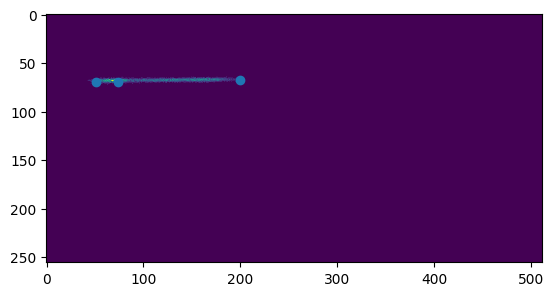

In [35]:
import matplotlib.pyplot as plt
for charge, target in train_dataset.take(1):
    points = target[0, :].reshape(3, 2)
    plt.imshow(charge[0, :, :])
    plt.scatter(points[:, 0], points[:, 1])